# Classification of drawings made in the game 'Quick, draw!'

Author: Sandra Bae and Evan Dumas, June 2018 

In this project I will use scikit-learn and Keras to compare different machine learning algorithms to classify drawings made in the game ['Quick, draw!'](https://quickdraw.withgoogle.com/). In this game, people are told what they should draw in less than 20 seconds, while a neural network is predicting in real-time what it sees in the drawing. Once the prediction is correct, you can't finish your drawing, which might explain the rather minimalistic style of the drawings. It's not the most fun game, but certainly a great way of collecting data for machine learning. 

A huge dataset has been made publically available, more information is available in this [Github repository](https://github.com/googlecreativelab/quickdraw-dataset). I have used [this data set](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1), which is already preprocessed to a uniform 28x28 pixel image size. Since the complete data set includes over 50 million pictures and 345 categories, I will only use a small subset of it.


In [1]:
# Imports

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


## Binary Classification

I will start with only 2 classes, cat and sheep drawings. There [data](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1) for each class consists of around 125,000 drawings (rows) and 784 pixels (columns) per drawing.

In [3]:
# load the data
cat = np.load('data/cat.npy')
sheep = np.load('data/sheep.npy')

print(cat.shape)
print(sheep.shape)

(123202, 784)
(126121, 784)


In [4]:
# add a column with labels, 0=cat, 1=sheep
cat = np.c_[cat, np.zeros(len(cat))]
sheep = np.c_[sheep, np.ones(len(sheep))]

A useful function: I wrote one to plot 28x28 pixel images from numpy arrays.

In [5]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

Let's take a look at some drawings. The quality and style of the drawings varies greatly, so we should expect a lower accuracy than in other tasks such as digit recognition. Also, the data set is not completely cleaned.

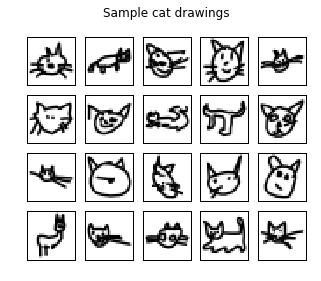

In [7]:
plot_samples(cat, title='Sample cat drawings\n')

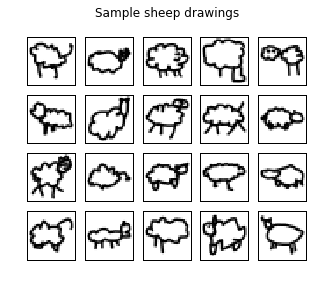

In [8]:
plot_samples(sheep, title='Sample sheep drawings\n')

Create the matrices for scikit-learn (5'000 cat and sheep images each):

In [9]:
# merge the cat and sheep arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = np.concatenate((cat[:5000,:-1], sheep[:5000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((cat[:5000,-1], sheep[:5000,-1]), axis=0).astype('float32') # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# I will use a 50:50 split, since I want to start by training the models on 5'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

## Random Forest

I will first try out a simple random forest classifier using the default options (except for random_state for reproducibility and n_jobs=-1 to use multiple CPUs):

In [10]:
%%time

clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
print(clf_rf)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('Random forest accuracy: ',acc_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Random forest accuracy:  0.8672
Wall time: 333 ms


The most important argument, n_estimators (= number of trees in the forest), is set to 10 by default. Let's try some larger values, as that should increase accuracy. GridSearchCV is very useful for optimizing parameters in scikit-learn.

In [11]:
parameters = {'n_estimators': [10,20,40,60,80,100,120,140,160]}

In [12]:
%%time

clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)
rf = GridSearchCV(clf_rf, parameters, n_jobs=-1)
rf.fit(X_train, y_train)

results = pd.DataFrame(rf.cv_results_)

Wall time: 27.7 s


In [13]:
results.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
7,4.536410,0.737712,0.9160,1.0000,140,{'n_estimators': 140},1,0.915468,1.000000,0.914166,1.000000,0.918367,1.000000,0.519852,0.593673,0.001756,0.000000
6,4.179469,0.662638,0.9150,1.0000,120,{'n_estimators': 120},2,0.912470,1.000000,0.917167,1.000000,0.915366,1.000000,0.530962,0.422203,0.001935,0.000000
8,4.105458,0.173790,0.9150,1.0000,160,{'n_estimators': 160},2,0.914269,1.000000,0.914166,1.000000,0.916567,1.000000,1.566813,0.095412,0.001108,0.000000
5,3.339449,0.253681,0.9148,1.0000,100,{'n_estimators': 100},4,0.913669,1.000000,0.914166,1.000000,0.916567,1.000000,0.151762,0.055651,0.001265,0.000000
4,2.442926,0.520429,0.9130,1.0000,80,{'n_estimators': 80},5,0.913669,1.000000,0.910564,1.000000,0.914766,1.000000,0.249435,0.581260,0.001779,0.000000
3,1.799945,0.644459,0.9102,1.0000,60,{'n_estimators': 60},6,0.908873,1.000000,0.909964,1.000000,0.911765,1.000000,0.275570,0.480345,0.001192,0.000000
2,1.337450,0.706503,0.9062,1.0000,40,{'n_estimators': 40},7,0.904676,1.000000,0.906963,1.000000,0.906963,1.000000,0.280584,0.408518,0.001078,0.000000
1,0.536547,0.165284,0.8968,0.9999,20,{'n_estimators': 20},8,0.895084,1.000000,0.891957,0.999700,0.903361,1.000000,0.011206,0.036068,0.004811,0.000141
0,0.279201,0.227662,0.8838,0.9963,10,{'n_estimators': 10},9,0.881894,0.996098,0.873349,0.996401,0.896158,0.996401,0.040739,0.078643,0.009407,0.000142


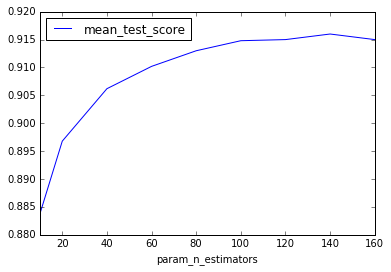

In [14]:
results.plot('param_n_estimators','mean_test_score');

The accuracy plateaus after about 100 trees, I will therfore use this parameter from here on.

We can visualize the model to see which pixels had the highest importance:

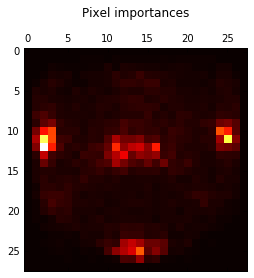

In [17]:
importances = clf_rf.feature_importances_
importances = importances.reshape((28,28))
plt.matshow(importances, cmap=plt.cm.hot);
plt.title('Pixel importances\n');

As could be expected, corners have a very low importance, as they are mostly blank. The left, right, middle and bottom part of the picture are most important. Looking at the pictures of cats and sheeps, it seems that the middle is mostly blank in sheeps, but not in cats. So pixels there probably indicate a cat image. The other 'hot' areas are less clear to me after a quick inspection of the images.

## K-Nearest Neighbors (KNN)

Next, I will try out a KNN classifier:

In [18]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
print(clf_knn)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
KNN accuracy:  0.9218
Wall time: 16 s


The KNN classifier looks promising, let's test different values of K:

In [19]:
%%time

parameters = {'n_neighbors': [1,3,5,7,9,11]}

clf_knn = KNeighborsClassifier(n_jobs=-1)
knn = GridSearchCV(clf_knn, parameters, n_jobs=-1)
knn.fit(X_train, y_train)

results_knn = pd.DataFrame(knn.cv_results_)

Wall time: 2min 50s


In [20]:
results_knn.sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,1.090484,12.000963,0.9216,0.9444,5,{'n_neighbors': 5},1,0.921463,0.944778,0.920768,0.943611,0.922569,0.944811,0.260144,0.537086,0.000741,0.000558
3,1.004534,12.362510,0.9210,0.9375,7,{'n_neighbors': 7},2,0.917866,0.937275,0.922569,0.938812,0.922569,0.936413,0.265598,0.398817,0.002218,0.000992
4,1.097780,13.028088,0.9200,0.9333,9,{'n_neighbors': 9},3,0.919664,0.931573,0.925570,0.934013,0.914766,0.934313,0.116241,0.504523,0.004416,0.001227
1,0.656531,11.819406,0.9188,0.9543,3,{'n_neighbors': 3},4,0.916067,0.952881,0.919568,0.955909,0.920768,0.954109,0.053521,0.742132,0.001995,0.001243
5,1.447028,10.433746,0.9152,0.9277,11,{'n_neighbors': 11},5,0.910671,0.928571,0.920768,0.928314,0.914166,0.926215,0.311654,2.412591,0.004187,0.001056
0,0.490201,12.068546,0.9098,1.0000,1,{'n_neighbors': 1},6,0.911871,1.000000,0.904562,1.000000,0.912965,1.000000,0.083732,0.476223,0.003730,0.000000


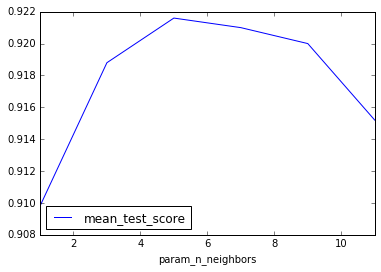

In [21]:
results_knn.plot('param_n_neighbors','mean_test_score');

The default option of k=5 seems to be optimal.
The KNN classifier is quite a bit more accurate than the random forest, but it also takes much longer (particularly the classification of new examples).

## Convolutional Neural Network (CNN)

Let's try out a Convolutional Neural Network (CNN) with Keras. I will use a model from this [tutorial](http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/) by Jason Brownlee. It has the following 9 layers:

1. Convolutional layer with 30 feature maps of size 5×5. 
2. Pooling layer taking the max over 2*2 patches. 
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%. 
6. Flatten layer. 
7. Fully connected layer with 128 neurons and rectifier activation. 
8. Fully connected layer with 50 neurons and rectifier activation. 
9. Output layer.

Keras requires one hot encoding of the y labels:

In [29]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

We also need to reshape the images to the original 28x28 shape, which gives the neural net additional information compared to a 784x1 vector.

In [30]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [31]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
%%time

np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 5000 samples, validate on 5000 samples
Epoch 1/10
5000/5000 [==============================] - 24s - loss: 0.5191 - acc: 0.7712 - val_loss: 0.3483 - val_acc: 0.8426
Epoch 2/10
5000/5000 [==============================] - 25s - loss: 0.2810 - acc: 0.8844 - val_loss: 0.2480 - val_acc: 0.9072
Epoch 3/10
5000/5000 [==============================] - 23s - loss: 0.2197 - acc: 0.9134 - val_loss: 0.2020 - val_acc: 0.9208
Epoch 4/10
5000/5000 [==============================] - 23s - loss: 0.1790 - acc: 0.9316 - val_loss: 0.1793 - val_acc: 0.9284
Epoch 5/10
5000/5000 [==============================] - 23s - loss: 0.1691 - acc: 0.9372 - val_loss: 0.1802 - val_acc: 0.9302
Epoch 6/10
5000/5000 [==============================] - 24s - loss: 0.1547 - acc: 0.9412 - val_loss: 0.1624 - val_acc: 0.9354
Epoch 7/10
5000/5000 [==============================] - 24s - loss: 0.1406 - acc: 0.9472 - val_loss: 0.1522 - val_acc: 0.9398
Epoch 8/10
5000/5000 [==============================] - 24s - loss: 0.

As expected for an image classification task, the CNN has a very high accuracy with over 94%. But it also required the longest training time.

## Comparing different methods

Next, I will compare the most promising algorithms using different numbers of training examples.

In [33]:
%%time

np.random.seed(0)

N_train = [500, 2000, 5000, 10000, 15000] # the number of training examples to be used
acc_scores = pd.DataFrame()

for i in N_train:
    # preprocessing as before with different sample sizes:
    X = np.concatenate((cat[:i,:-1], sheep[:i,:-1]), axis=0).astype('float32') 
    y = np.concatenate((cat[:i,-1], sheep[:i,-1]), axis=0).astype('float32') 
    X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)
    
    # run the different scikit-learn models:
    clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    acc_rf = clf_rf.score(X_test,y_test)
    acc_scores.set_value('RF', i, acc_rf)
    
    clf_knn = KNeighborsClassifier(n_jobs=-1)
    clf_knn.fit(X_train, y_train)
    acc_knn = clf_knn.score(X_test,y_test)
    acc_scores.set_value('KNN', i, acc_knn)
    
    # preprocessing for keras:
    y_train_cnn = np_utils.to_categorical(y_train)
    y_test_cnn = np_utils.to_categorical(y_test)
    num_classes = y_test_cnn.shape[1]
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
    X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')
    
    # run the keras model:
    model = cnn_model()
    model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200, verbose=0)
    scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
    acc_scores.set_value('CNN', i, scores[1])
    

Wall time: 34min 55s


## Multi-class Classification

Now let's make the classification a bit more difficult by comparing 5 classes:

In [45]:
# load the data
book = np.load("data/book.npy")
basket = np.load("data/basket.npy")

The data preprocessing is similar as in the case for 2 classes:

In [ ]:
# add a column with labels
book = np.c_[book, np.full((len(book)),2.)]
basket = np.c_[basket, np.full((len(basket)),3.)]

Create the matrices for scikit-learn (5'000 images per class):

In [47]:
X = np.concatenate((cat[:5000,:-1], sheep[:5000,:-1], book[:5000,:-1], basket[:5000,:-1]),
                    axis=0).astype('float32') # all columns but the last
y = np.concatenate((cat[:5000,-1], sheep[:5000,-1], book[:5000,-1], basket[:5000,-1]),
                   axis=0).astype('float32') # the last column

X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

Use different scikit-learn algorithms to make predictions:

In [48]:
%%time

clf_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print ('random forest accuracy: ',acc_rf)

random forest accuracy:  0.79104
Wall time: 8.7 s


In [49]:
%%time 

clf_knn = KNeighborsClassifier(n_jobs=-1)
clf_knn.fit(X_train, y_train)
y_pred_knn = clf_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print ('KNN accuracy: ',acc_knn)

KNN accuracy:  0.8236
Wall time: 1min 40s


Preprocessing for Keras:

In [51]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [52]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

In [53]:
%%time

# build the model
model = cnn_model()
# Fit the model
model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 66s - loss: 1.0823 - acc: 0.5662 - val_loss: 0.6821 - val_acc: 0.7490
Epoch 2/10
12500/12500 [==============================] - 72s - loss: 0.6352 - acc: 0.7742 - val_loss: 0.5268 - val_acc: 0.8140
Epoch 3/10
12500/12500 [==============================] - 66s - loss: 0.5167 - acc: 0.8202 - val_loss: 0.4372 - val_acc: 0.8524
Epoch 4/10
12500/12500 [==============================] - 62s - loss: 0.4612 - acc: 0.8410 - val_loss: 0.3947 - val_acc: 0.8688
Epoch 5/10
12500/12500 [==============================] - 60s - loss: 0.4161 - acc: 0.8576 - val_loss: 0.3731 - val_acc: 0.8786
Epoch 6/10
12500/12500 [==============================] - 60s - loss: 0.3812 - acc: 0.8710 - val_loss: 0.3428 - val_acc: 0.8908
Epoch 7/10
12500/12500 [==============================] - 60s - loss: 0.3585 - acc: 0.8773 - val_loss: 0.3245 - val_acc: 0.8968
Epoch 8/10
12500/12500 [==============================

Again, the CNN with Keras performed best.

It seems that there is still some room for improvement. Notably, I have used just about 2% of the pictures for training. By increasing that number, big increases in accuracy would certainly be possible.